# Training New Bot Detection Models
Using RNN, LSTM, and ConvLSTM models with suitable complexity.
Adapted from experiment.ipynb style.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, ConvLSTM2D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

# Set display options
plt.style.use('ggplot')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

2025-04-23 22:09:57.652325: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 22:09:57.668410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745446197.686665 1501059 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745446197.692623 1501059 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745446197.706926 1501059 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Paths to datasets
# DATA_DIR = "Dataset"
CLEAN_TRAIN_PATH = "clean_train.csv"
CLEAN_TEST_PATH = "clean_test.csv"
NOISY_TRAIN_PATH = "noisy_train.csv"
NOISY_TEST_PATH = "noisy_test.csv"

# Load datasets
clean_train = pd.read_csv(CLEAN_TRAIN_PATH)
clean_test = pd.read_csv(CLEAN_TEST_PATH)
noisy_train = pd.read_csv(NOISY_TRAIN_PATH)
noisy_test = pd.read_csv(NOISY_TEST_PATH)

# Dataset dictionary
datasets = {
    'clean_train': clean_train,
    'clean_test': clean_test,
    'noisy_train': noisy_train,
    'noisy_test': noisy_test
}

In [3]:
# Feature identification
def get_feature_types(df):
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = df.select_dtypes(include=['object', 'bool']).columns.tolist()
    for col in ['is_bot', 'user_id']:
        if col in numerical_features:
            numerical_features.remove(col)
        if col in categorical_features:
            categorical_features.remove(col)
    return numerical_features, categorical_features

num_features, cat_features = get_feature_types(clean_train)
print("Numerical features:", num_features)
print("Categorical features:", cat_features)

Numerical features: ['login_attempts', 'failed_logins', 'ip_rep_score', 'session_duration_deviation', 'network_packet_size_variance', 'mouse_speed', 'typing_speed']
Categorical features: ['unusual_time_access', 'browser_type', 'new_device_login', 'day_of_week', 'time_of_day']



=== EDA for Clean Training Data ===


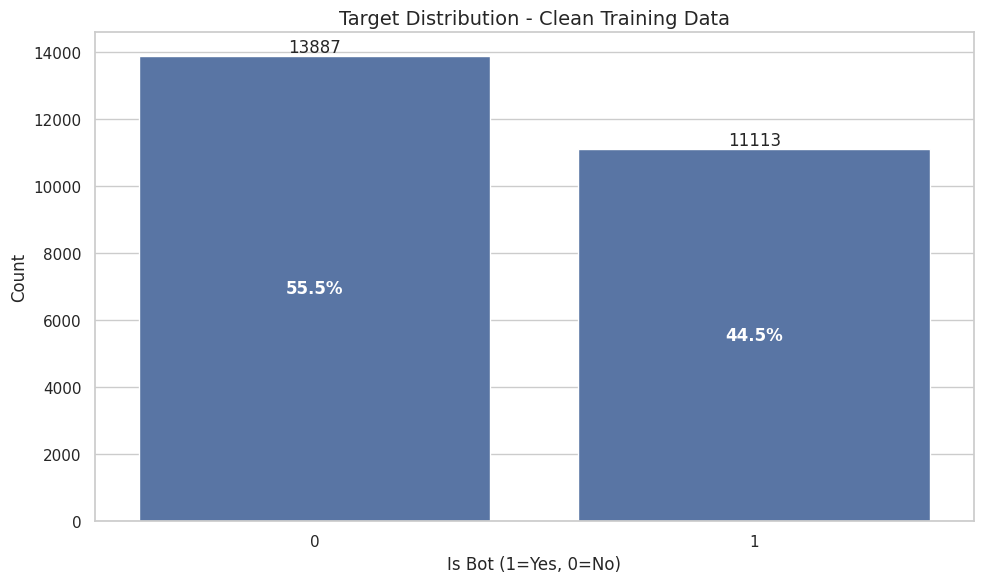

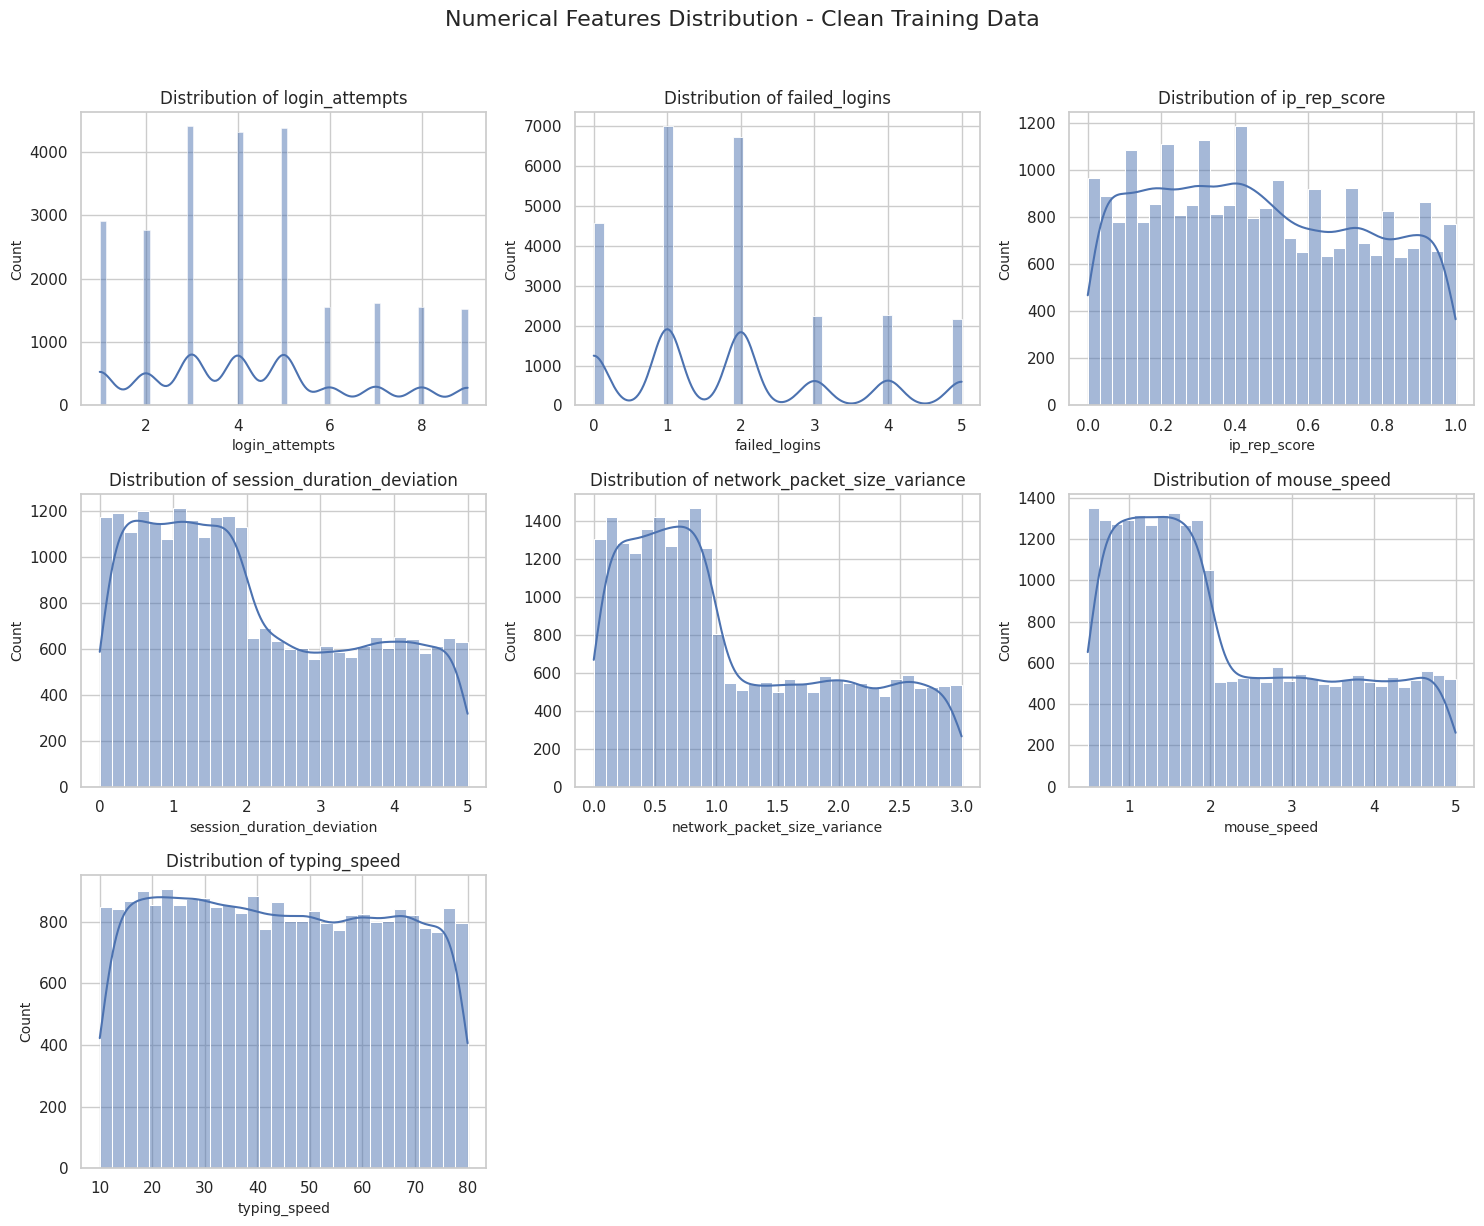

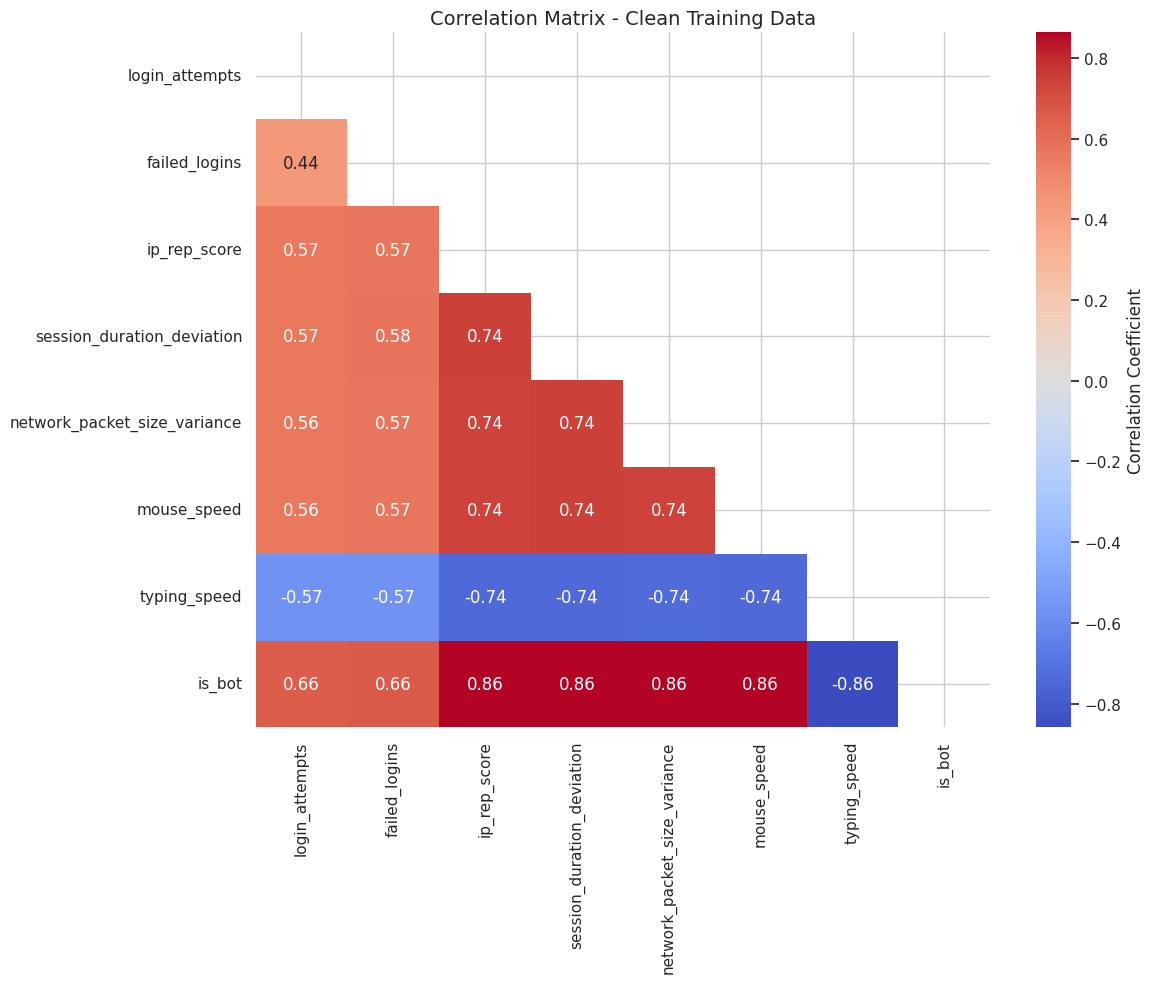


=== EDA for Noisy Training Data ===


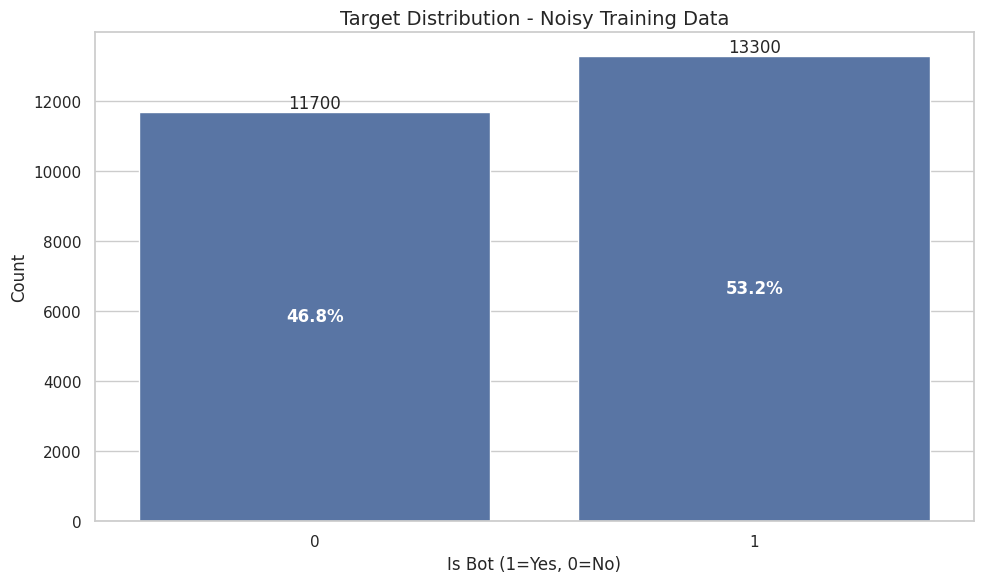

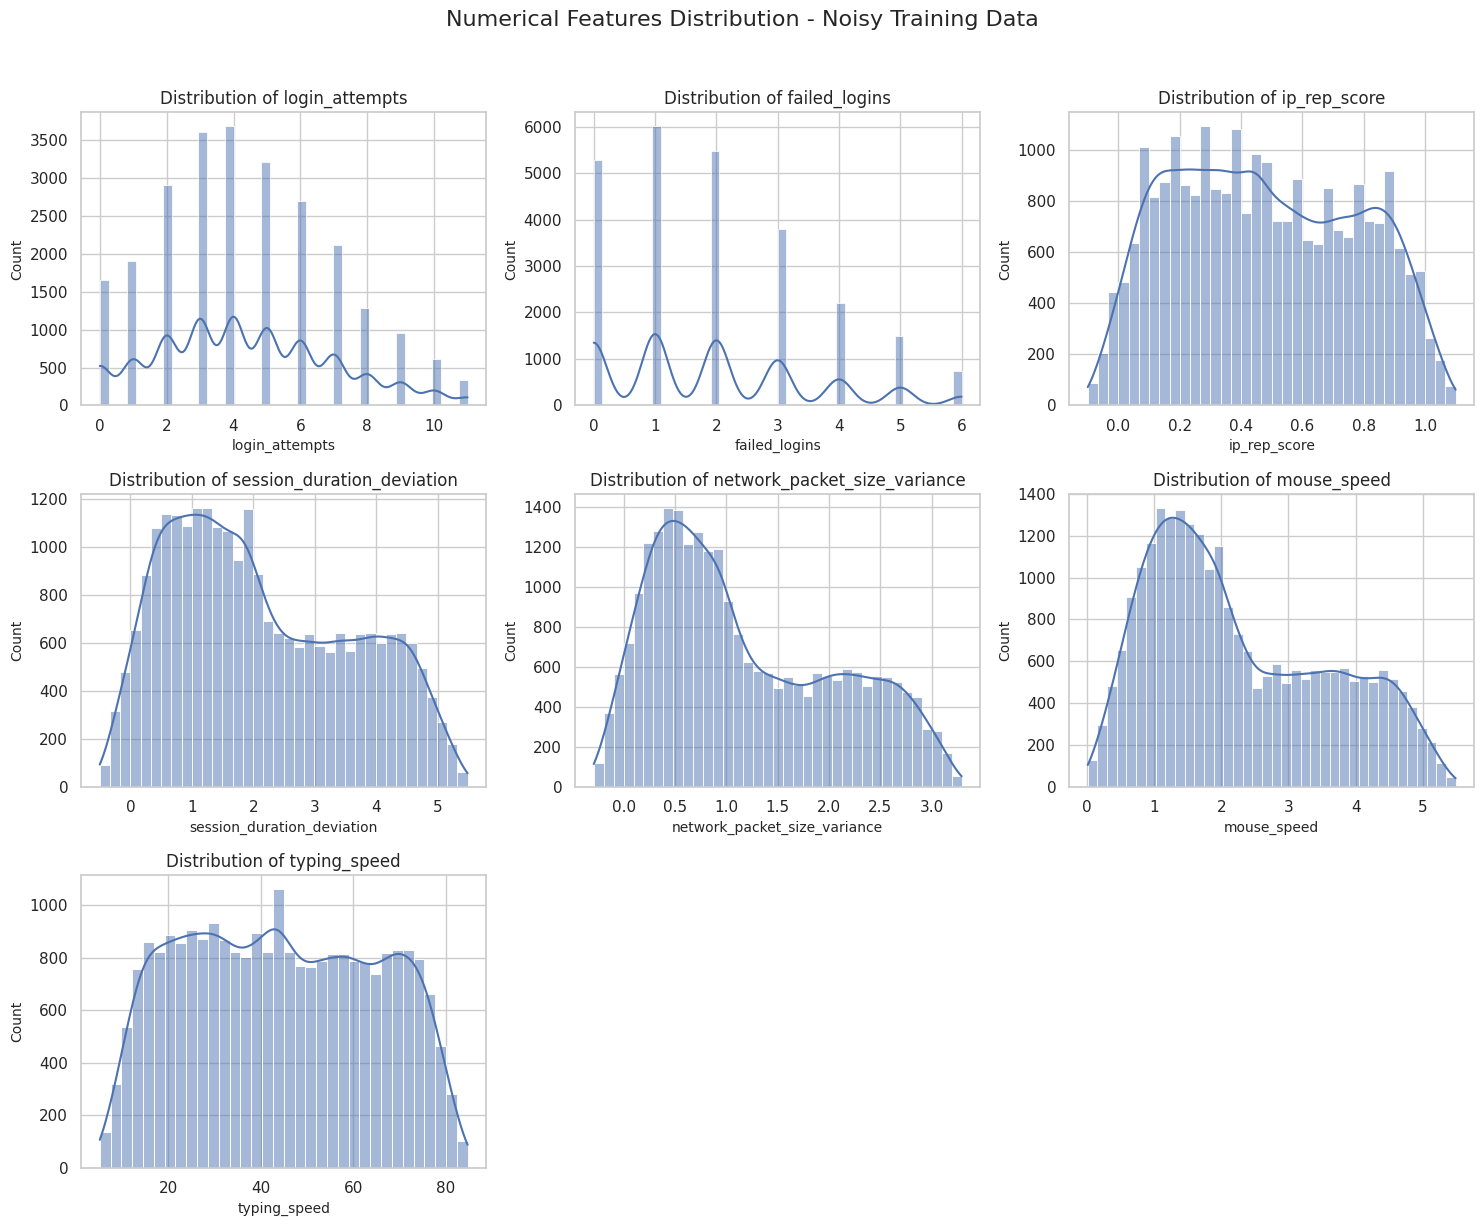

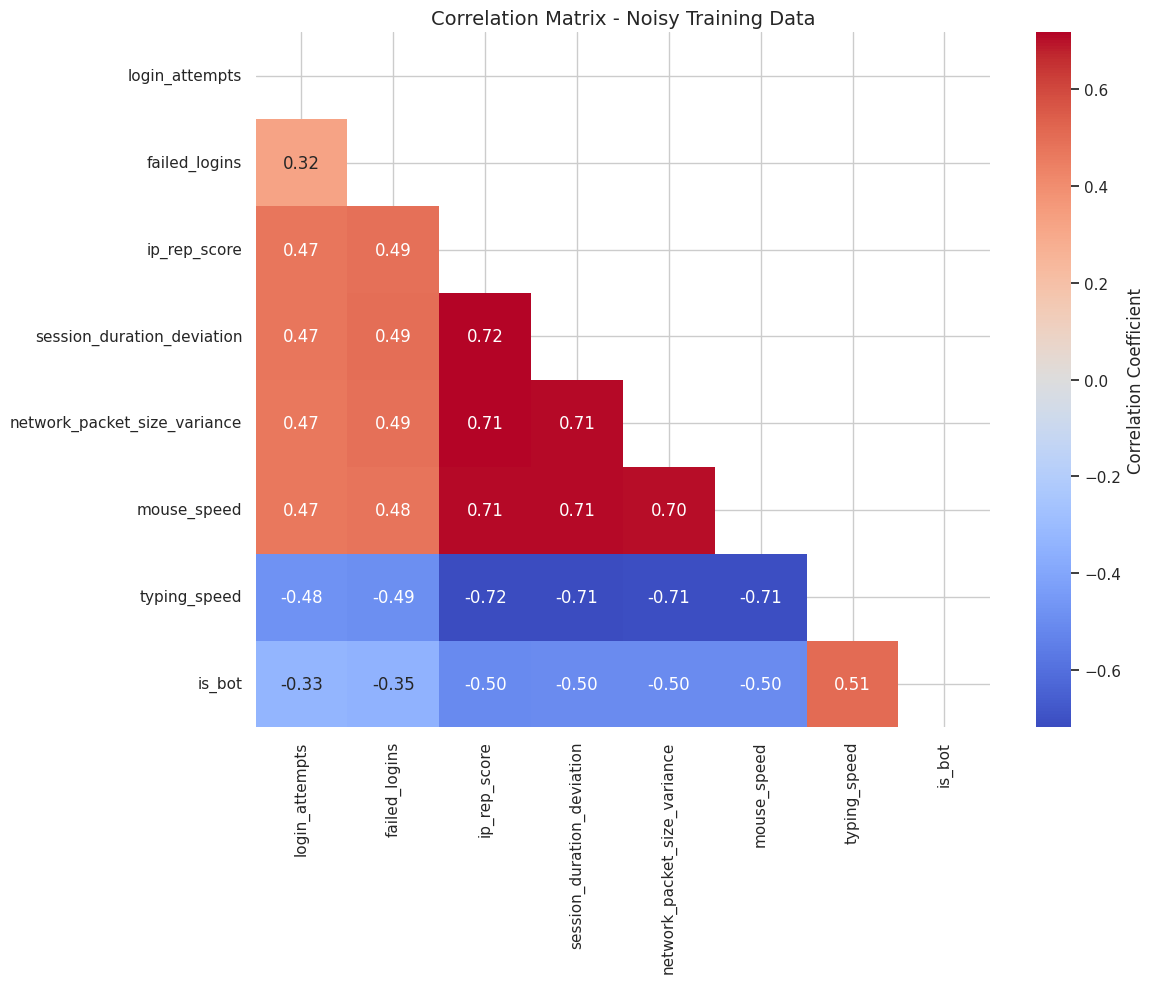

In [4]:
# Exploratory Data Analysis
def perform_eda(df, name):
    print(f"\n=== EDA for {name} ===")
    df_eda = df.copy()
    for col in num_features:
        if col in df_eda.columns:
            df_eda[col].fillna(df_eda[col].median(), inplace=True)
    for col in cat_features:
        if col in df_eda.columns:
            df_eda[col].fillna(df_eda[col].mode()[0] if not df_eda[col].mode().empty else "Unknown", inplace=True)
    if df_eda['is_bot'].dtype == 'object' or df_eda['is_bot'].dtype == 'bool':
        df_eda['is_bot'] = df_eda['is_bot'].map({'True': 1, 'False': 0, True: 1, False: 0})
    plt.close('all')
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='is_bot', data=df_eda)
    plt.title(f'Target Distribution - {name}', fontsize=14)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='bottom', fontsize=12)
    total = len(df_eda)
    for i, p in enumerate(ax.patches):
        percentage = f'{100 * p.get_height() / total:.1f}%'
        ax.annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()/2), ha='center', va='center', fontsize=12, color='white', fontweight='bold')
    plt.xlabel('Is Bot (1=Yes, 0=No)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.tight_layout()
    plt.show()
    valid_num_features = [col for col in num_features if col in df_eda.columns]
    if valid_num_features:
        n_cols = min(3, len(valid_num_features))
        n_rows = (len(valid_num_features) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        for i, feature in enumerate(valid_num_features):
            if i < len(axes):
                sns.histplot(df_eda[feature], kde=True, ax=axes[i])
                axes[i].set_title(f'Distribution of {feature}', fontsize=12)
                axes[i].set_xlabel(feature, fontsize=10)
                axes[i].set_ylabel('Count', fontsize=10)
        for j in range(len(valid_num_features), len(axes)):
            axes[j].set_visible(False)
        plt.suptitle(f'Numerical Features Distribution - {name}', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
    valid_corr_features = [col for col in num_features + ['is_bot'] if col in df_eda.columns]
    if len(valid_corr_features) > 1:
        plt.figure(figsize=(12, 10))
        corr = df_eda[valid_corr_features].corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
        plt.title(f'Correlation Matrix - {name}', fontsize=14)
        plt.tight_layout()
        plt.show()

perform_eda(clean_train, 'Clean Training Data')
perform_eda(noisy_train, 'Noisy Training Data')

In [5]:
# Preprocessing pipeline
def create_preprocessing_pipeline():
    numerical_transformer = make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    )
    preprocessor = make_column_transformer(
        (numerical_transformer, num_features),
        (categorical_transformer, cat_features),
        remainder='drop'
    )
    return preprocessor

def process_data(train_df, test_df):
    preprocessor = create_preprocessing_pipeline()
    X_train = train_df.drop(['is_bot', 'user_id'], axis=1)
    y_train = train_df['is_bot'].map({'True': 1, 'False': 0, True: 1, False: 0})
    X_train_processed = preprocessor.fit_transform(X_train)
    num_feature_names = num_features
    cat_feature_names = preprocessor.named_transformers_['pipeline-2']['onehotencoder'].get_feature_names_out(cat_features)
    all_feature_names = list(num_feature_names) + list(cat_feature_names)
    X_train_proc = pd.DataFrame(X_train_processed, columns=all_feature_names)
    X_test = test_df.drop(['is_bot', 'user_id'], axis=1)
    y_test = test_df['is_bot'].map({'True': 1, 'False': 0, True: 1, False: 0})
    X_test_processed = preprocessor.transform(X_test)
    X_test_proc = pd.DataFrame(X_test_processed, columns=all_feature_names)
    return X_train_proc, y_train, X_test_proc, y_test, preprocessor

X_clean_train, y_clean_train, X_clean_test, y_clean_test, clean_preprocessor = process_data(clean_train, clean_test)
X_noisy_train, y_noisy_train, X_noisy_test, y_noisy_test, noisy_preprocessor = process_data(noisy_train, noisy_test)

In [6]:
# Prepare RNN data
def prepare_rnn_data(X, y=None):
    X_rnn = X.values.reshape(X.shape[0], 1, X.shape[1])
    return X_rnn, y

processed_data = {
    'clean': {
        'X_train': X_clean_train,
        'y_train': y_clean_train,
        'X_test': X_clean_test,
        'y_test': y_clean_test,
        'X_train_rnn': prepare_rnn_data(X_clean_train)[0],
        'y_train_rnn': y_clean_train,
        'X_test_rnn': prepare_rnn_data(X_clean_test)[0],
        'preprocessor': clean_preprocessor
    },
    'noisy': {
        'X_train': X_noisy_train,
        'y_train': y_noisy_train,
        'X_test': X_noisy_test,
        'y_test': y_noisy_test,
        'X_train_rnn': prepare_rnn_data(X_noisy_train)[0],
        'y_train_rnn': y_noisy_train,
        'X_test_rnn': prepare_rnn_data(X_noisy_test)[0],
        'preprocessor': noisy_preprocessor
    }
}


=== Feature Importance - Clean Training Data ===


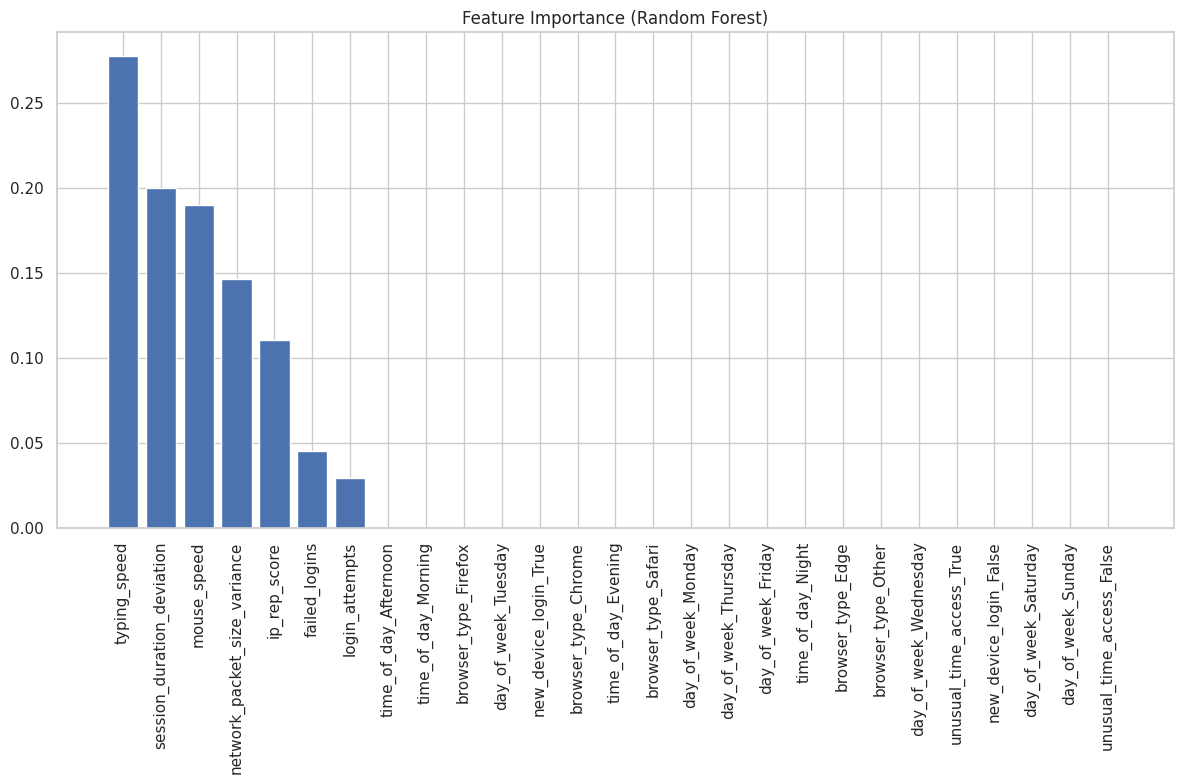

Top 20 most important features:


,Feature,Importance
0,typing_speed,0.277675
1,session_duration_deviation,0.200064
2,mouse_speed,0.189913
3,network_packet_size_variance,0.146411
4,ip_rep_score,0.110894
5,failed_logins,0.045357
6,login_attempts,0.029632
7,time_of_day_Afternoon,0.000011
8,time_of_day_Morning,0.000007
9,browser_type_Firefox,0.000006



=== Feature Importance - Noisy Training Data ===


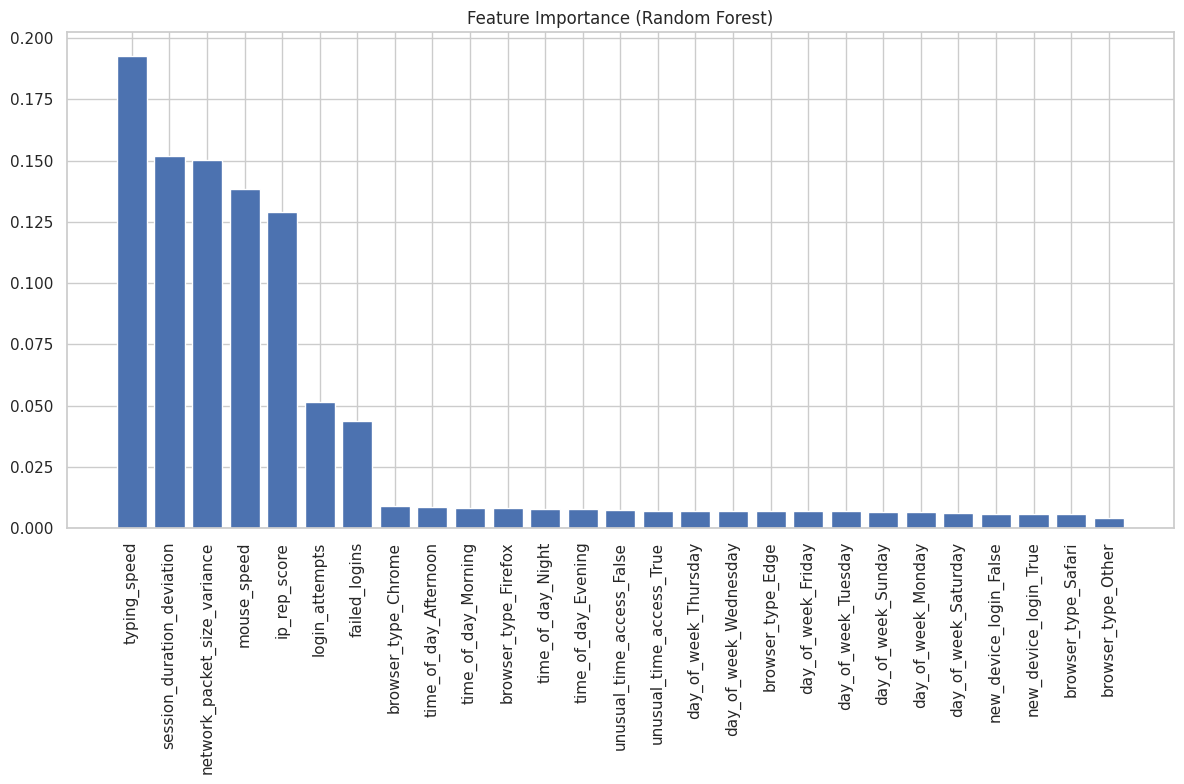

Top 20 most important features:


,Feature,Importance
0,typing_speed,0.192635
1,session_duration_deviation,0.151802
2,network_packet_size_variance,0.150277
3,mouse_speed,0.138323
4,ip_rep_score,0.129182
5,login_attempts,0.051646
6,failed_logins,0.043875
7,browser_type_Chrome,0.009188
8,time_of_day_Afternoon,0.008598
9,time_of_day_Morning,0.008404


In [7]:
# Feature importance analysis
def analyze_feature_importance(X_train, y_train, feature_names):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importance (Random Forest)')
    plt.bar(range(X_train.shape[1]), importances[indices], align='center')
    plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
    importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices],
        'Importance': importances[indices]
    }).head(20)
    print("Top 20 most important features:")
    display(importance_df)
    return importance_df

print("\n=== Feature Importance - Clean Training Data ===")
clean_importance = analyze_feature_importance(processed_data['clean']['X_train'], processed_data['clean']['y_train'], processed_data['clean']['X_train'].columns.tolist())

print("\n=== Feature Importance - Noisy Training Data ===")
noisy_importance = analyze_feature_importance(processed_data['noisy']['X_train'], processed_data['noisy']['y_train'], processed_data['noisy']['X_train'].columns.tolist())

In [8]:
# Model evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    y_prob = model.predict(X_test).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
    }
    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print(f"\nClassification Report - {model_name}:")
    print(classification_report(y_test, y_pred))
    return metrics

In [9]:
# Model training and evaluation
def train_and_evaluate_models(X_train, y_train, X_test, y_test, X_train_rnn=None, y_train_rnn=None, X_test_rnn=None, data_type='Clean'):
    results = {}
    models = {}  # New dictionary to store models

    print(f"\n=== Training RNN ({data_type} Data) ===")
    rnn_model = Sequential([
        SimpleRNN(128, activation='relu', return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
        Dropout(0.3),
        SimpleRNN(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    rnn_history = rnn_model.fit(X_train_rnn, y_train_rnn, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)
    results['RNN'] = evaluate_model(rnn_model, X_test_rnn, y_test, f'RNN ({data_type})')
    models['RNN'] = rnn_model  # Store the model
    
    # Plot RNN training history
    plt.figure(figsize=(12, 6))
    plt.plot(rnn_history.history['accuracy'], label='Train Accuracy')
    plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('RNN Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"\n=== Training LSTM ({data_type} Data) ===")
    lstm_model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
        Dropout(0.3),
        LSTM(64, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    lstm_history = lstm_model.fit(X_train_rnn, y_train_rnn, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)
    results['LSTM'] = evaluate_model(lstm_model, X_test_rnn, y_test, f'LSTM ({data_type})')

    # Plot LSTM training history
    plt.figure(figsize=(12, 6))
    plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
    plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('LSTM Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"\n=== Training ConvLSTM ({data_type} Data) ===")
    X_train_conv = X_train_rnn.reshape((X_train_rnn.shape[0], X_train_rnn.shape[1], 1, X_train_rnn.shape[2], 1))
    X_test_conv = X_test_rnn.reshape((X_test_rnn.shape[0], X_test_rnn.shape[1], 1, X_test_rnn.shape[2], 1))
    convlstm_model = Sequential([
        ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', return_sequences=True, input_shape=(X_train_conv.shape[1], X_train_conv.shape[2], X_train_conv.shape[3], X_train_conv.shape[4])),
        Dropout(0.3),
        ConvLSTM2D(filters=32, kernel_size=(1,3), activation='relu'),
        Dropout(0.3),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    convlstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    convlstm_history = convlstm_model.fit(X_train_conv, y_train_rnn, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)
    results['ConvLSTM'] = evaluate_model(convlstm_model, X_test_conv, y_test, f'ConvLSTM ({data_type})')

    # Plot ConvLSTM training history
    plt.figure(figsize=(12, 6))
    plt.plot(convlstm_history.history['accuracy'], label='Train Accuracy')
    plt.plot(convlstm_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('ConvLSTM Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()
     
    return results, models  # Now returning both results and models


=== Training RNN (Clean Data) ===
Epoch 1/50


W0000 00:00:1745446213.388032 1501059 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9759 - loss: 0.0863 - val_accuracy: 1.0000 - val_loss: 1.7535e-05
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 6.8025e-05 - val_accuracy: 1.0000 - val_loss: 2.2545e-06
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 8.2919e-05 - val_accuracy: 1.0000 - val_loss: 2.2322e-06
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.8153e-05 - val_accuracy: 1.0000 - val_loss: 2.1626e-07
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 3.0796e-05 - val_accuracy: 1.0000 - val_loss: 2.3678e-07
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 2.6034e-06 - val_accuracy: 1.0000 - val_loss: 1.3528e-07
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.5375e-06 - val_accuracy: 1.0000 - val_loss: 5.9877e-08
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy:

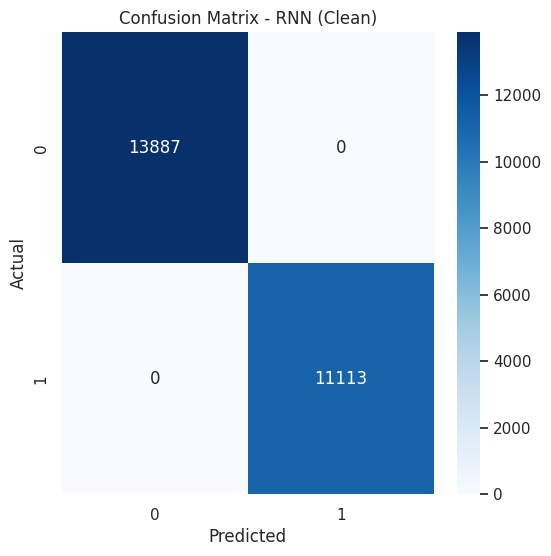


Classification Report - RNN (Clean):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13887
           1       1.00      1.00      1.00     11113

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000



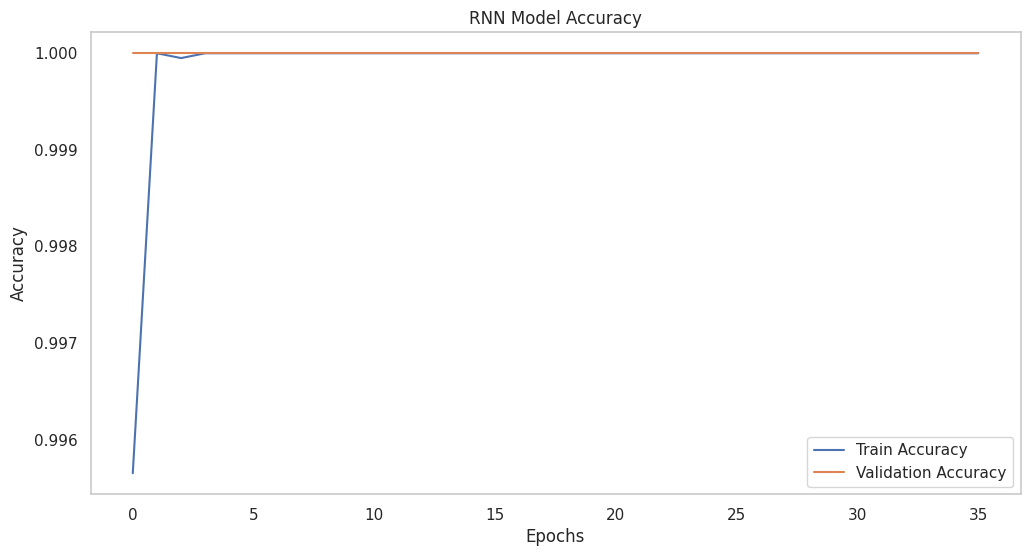


=== Training LSTM (Clean Data) ===
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9889 - loss: 0.1242 - val_accuracy: 1.0000 - val_loss: 1.2265e-04
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 5.2497e-05 - val_accuracy: 1.0000 - val_loss: 8.4847e-06
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.3013e-05 - val_accuracy: 1.0000 - val_loss: 3.0176e-06
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 5.1365e-06 - val_accuracy: 1.0000 - val_loss: 1.5602e-06
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 3.5043e-06 - val_accuracy: 1.0000 - val_loss: 9.9061e-07
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.4735e-06 - val_accuracy: 1.0000 - val_loss: 6.5622e-07
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 3.5157e-06 - val_accuracy: 1.0000 - val_loss: 1.3089e-06
Epoch 8/50
625/6

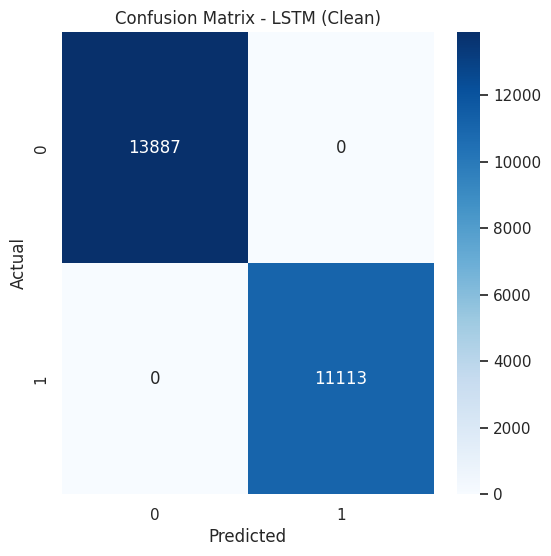


Classification Report - LSTM (Clean):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13887
           1       1.00      1.00      1.00     11113

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000



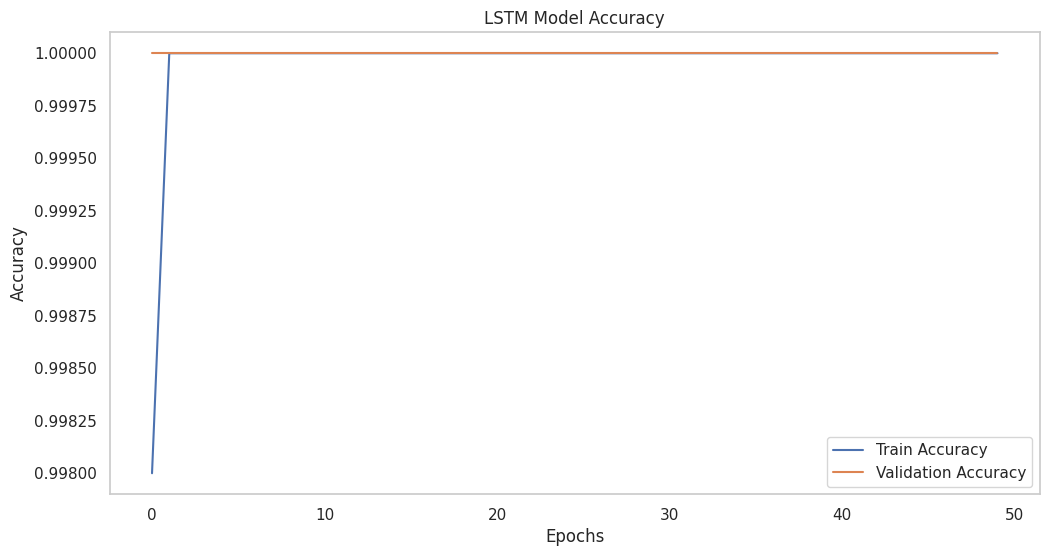


=== Training ConvLSTM (Clean Data) ===
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9827 - loss: 0.1615 - val_accuracy: 1.0000 - val_loss: 7.2904e-05
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 1.0000 - loss: 6.3663e-05 - val_accuracy: 1.0000 - val_loss: 4.1736e-05
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 1.0000 - loss: 3.2829e-05 - val_accuracy: 1.0000 - val_loss: 1.2977e-05
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 1.0000 - loss: 1.0386e-05 - val_accuracy: 1.0000 - val_loss: 2.2625e-06
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 1.0000 - loss: 4.0800e-06 - val_accuracy: 1.0000 - val_loss: 1.1573e-06
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 1.0000 - loss: 4.3143e-06 - val_accuracy: 1.0000 - val_loss: 9.3305e-07
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 1.0000 - loss: 1.3112e-06 - val_accuracy: 1.0000 - val_loss: 7.2339e-07
Epoch 8/50
6

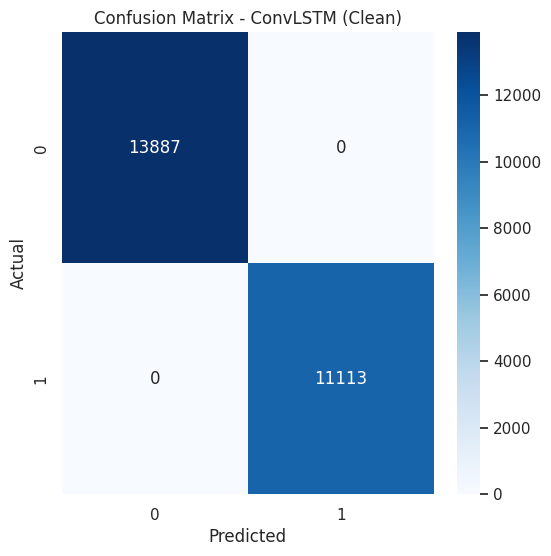


Classification Report - ConvLSTM (Clean):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13887
           1       1.00      1.00      1.00     11113

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000



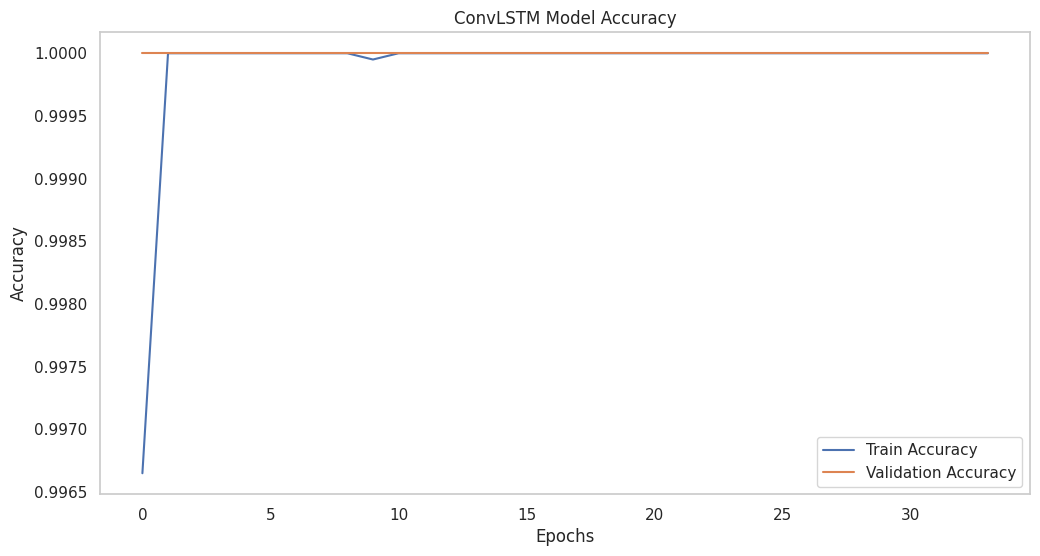

In [10]:
# # Train and evaluate on clean data
# clean_results = train_and_evaluate_models(
#     processed_data['clean']['X_train'],
#     processed_data['clean']['y_train'],
#     processed_data['clean']['X_test'],
#     processed_data['clean']['y_test'],
#     processed_data['clean']['X_train_rnn'],
#     processed_data['clean']['y_train_rnn'],
#     processed_data['clean']['X_test_rnn'],
#     'Clean'
# )

# Train and evaluate on clean data
clean_results, clean_models = train_and_evaluate_models(
    processed_data['clean']['X_train'],
    processed_data['clean']['y_train'],
    processed_data['clean']['X_test'],
    processed_data['clean']['y_test'],
    processed_data['clean']['X_train_rnn'],
    processed_data['clean']['y_train_rnn'],
    processed_data['clean']['X_test_rnn'],
    'Clean'
)



=== Training RNN (Noisy Data) ===
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7710 - loss: 0.5395 - val_accuracy: 0.7922 - val_loss: 0.5231
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8009 - loss: 0.5120 - val_accuracy: 0.7922 - val_loss: 0.5151
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8090 - loss: 0.4950 - val_accuracy: 0.7922 - val_loss: 0.5172
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8041 - loss: 0.5019 - val_accuracy: 0.7922 - val_loss: 0.5155
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8009 - loss: 0.5036 - val_accuracy: 0.7922 - val_loss: 0.5141
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8044 - loss: 0.4980 - val_accuracy: 0.7922 - val_loss: 0.5202
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7987 - loss: 0.5037 - val_accuracy: 0.7922 - val_loss: 0.5160
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.802

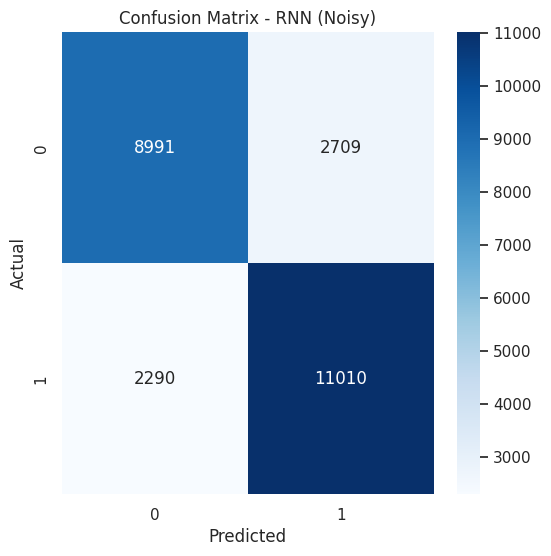


Classification Report - RNN (Noisy):
              precision    recall  f1-score   support

           0       0.80      0.77      0.78     11700
           1       0.80      0.83      0.81     13300

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



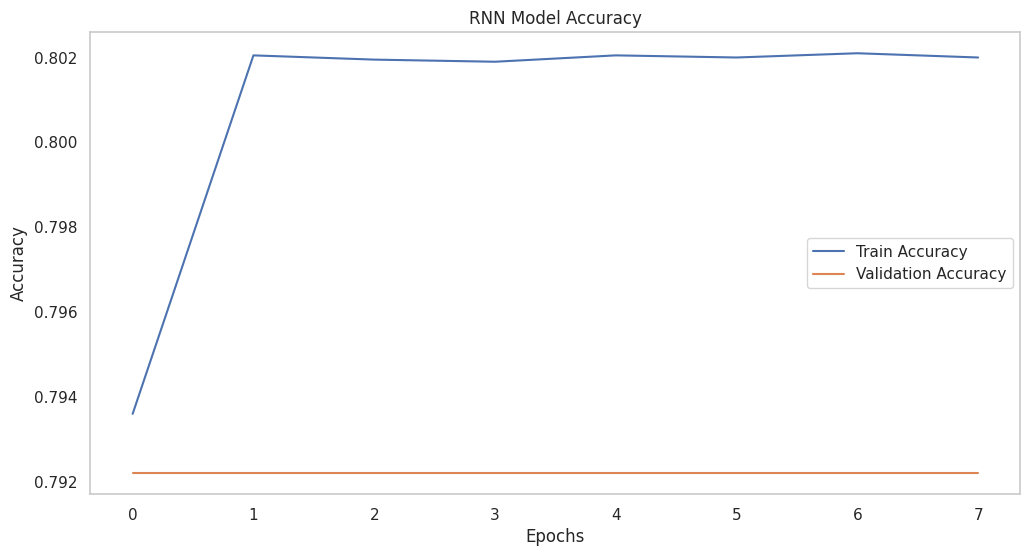


=== Training LSTM (Noisy Data) ===
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7951 - loss: 0.5335 - val_accuracy: 0.7922 - val_loss: 0.5168
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7985 - loss: 0.5057 - val_accuracy: 0.7922 - val_loss: 0.5142
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8052 - loss: 0.4957 - val_accuracy: 0.7922 - val_loss: 0.5134
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8033 - loss: 0.4988 - val_accuracy: 0.7924 - val_loss: 0.5129
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8050 - loss: 0.4959 - val_accuracy: 0.7920 - val_loss: 0.5127
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8081 - loss: 0.4909 - val_accuracy: 0.7920 - val_loss: 0.5134
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8082 - loss: 0.4908 - val_accuracy: 0.7920 - val_loss: 0.5139
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.80

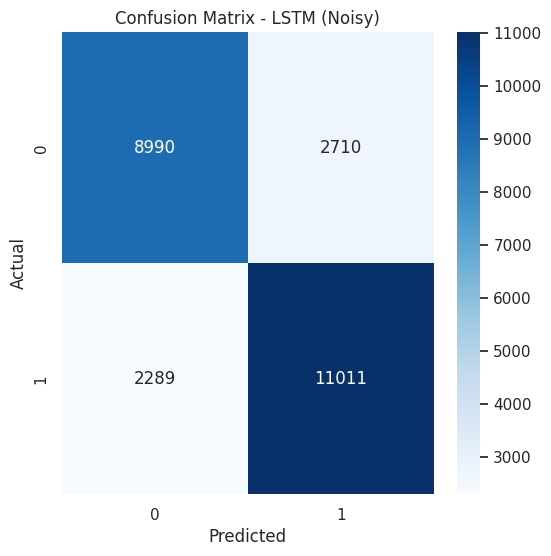


Classification Report - LSTM (Noisy):
              precision    recall  f1-score   support

           0       0.80      0.77      0.78     11700
           1       0.80      0.83      0.81     13300

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



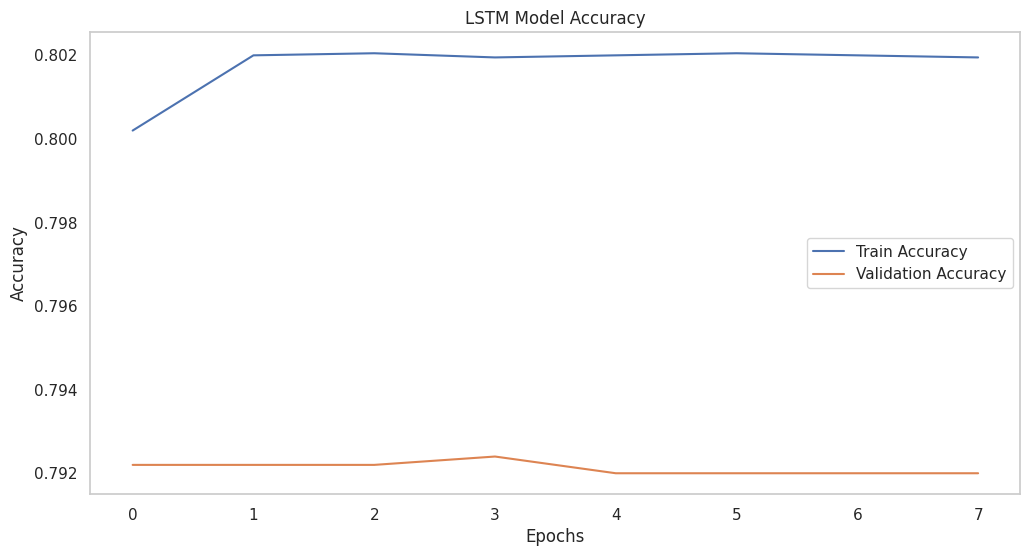


=== Training ConvLSTM (Noisy Data) ===
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7604 - loss: 0.5451 - val_accuracy: 0.7922 - val_loss: 0.5145
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8034 - loss: 0.4998 - val_accuracy: 0.7922 - val_loss: 0.5140
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8046 - loss: 0.4974 - val_accuracy: 0.7922 - val_loss: 0.5140
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7999 - loss: 0.5035 - val_accuracy: 0.7924 - val_loss: 0.5158
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8014 - loss: 0.5003 - val_accuracy: 0.7922 - val_loss: 0.5141
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


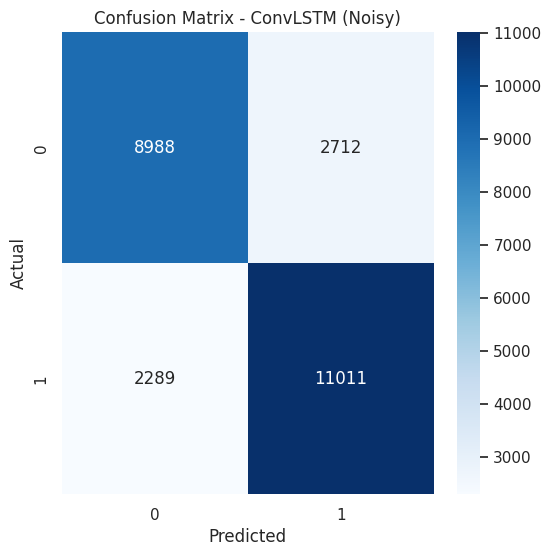


Classification Report - ConvLSTM (Noisy):
              precision    recall  f1-score   support

           0       0.80      0.77      0.78     11700
           1       0.80      0.83      0.81     13300

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



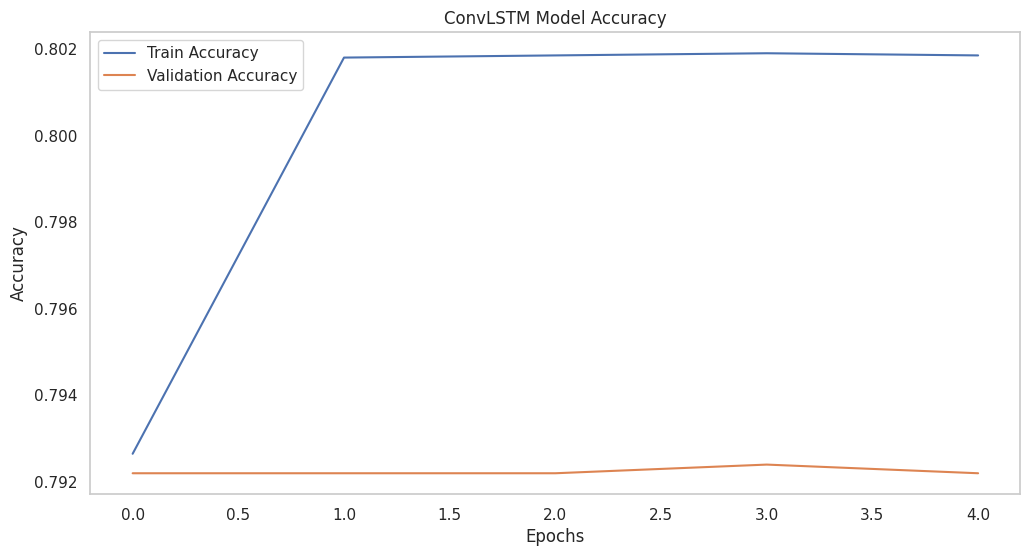

In [11]:
# # Train and evaluate on noisy data
# noisy_results = train_and_evaluate_models(
#     processed_data['noisy']['X_train'],
#     processed_data['noisy']['y_train'],
#     processed_data['noisy']['X_test'],
#     processed_data['noisy']['y_test'],
#     processed_data['noisy']['X_train_rnn'],
#     processed_data['noisy']['y_train_rnn'],
#     processed_data['noisy']['X_test_rnn'],
#     'Noisy'
# )

# Train and evaluate on noisy data
noisy_results, noisy_models = train_and_evaluate_models(
    processed_data['noisy']['X_train'],
    processed_data['noisy']['y_train'],
    processed_data['noisy']['X_test'],
    processed_data['noisy']['y_test'],
    processed_data['noisy']['X_train_rnn'],
    processed_data['noisy']['y_train_rnn'],
    processed_data['noisy']['X_test_rnn'],
    'Noisy'
)


=== Clean Model Performance ===


,Model,Dataset,accuracy,precision,recall,f1,roc_auc
0,RNN,Clean,1.0,1.0,1.0,1.0,1.0
1,LSTM,Clean,1.0,1.0,1.0,1.0,1.0
2,ConvLSTM,Clean,1.0,1.0,1.0,1.0,1.0



=== Noisy Model Performance ===


,Model,Dataset,accuracy,precision,recall,f1,roc_auc
0,RNN,Noisy,0.80004,0.802537,0.827820,0.814982,0.810288
1,LSTM,Noisy,0.80004,0.802493,0.827895,0.814996,0.806802
2,ConvLSTM,Noisy,0.79996,0.802376,0.827895,0.814935,0.800290


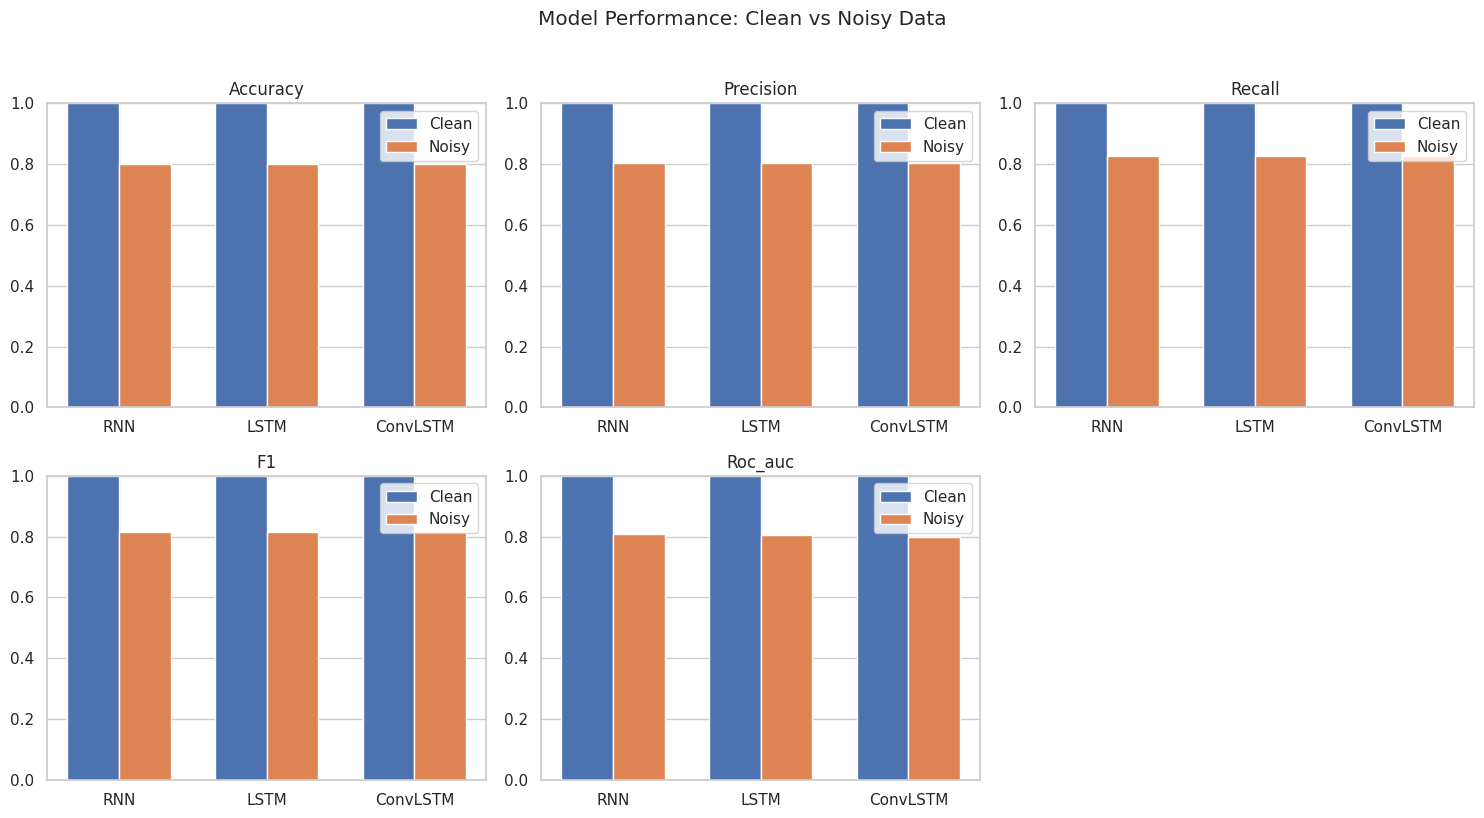

In [12]:
# # Create comparison dataframe
# def create_comparison_df(clean_results, noisy_results):
#     metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
#     comparison = []
#     for model in clean_results.keys():
#         clean_row = {'Model': model, 'Dataset': 'Clean'}
#         noisy_row = {'Model': model, 'Dataset': 'Noisy'}
#         for metric in metrics:
#             clean_row[metric] = clean_results[model][metric]
#             noisy_row[metric] = noisy_results.get(model, {}).get(metric, np.nan)
#         comparison.extend([clean_row, noisy_row])
#     return pd.DataFrame(comparison)

# comparison_df = create_comparison_df(clean_results, noisy_results)
# print("\n=== Model Performance Comparison ===")
# display(comparison_df)

def create_comparison_dfs(clean_results, noisy_results):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    # Initialize lists to hold rows for clean and noisy results
    clean_comparison = []
    noisy_comparison = []
    
    for model in clean_results.keys():
        # Create a row for clean results
        clean_row = {'Model': model, 'Dataset': 'Clean'}
        for metric in metrics:
            clean_row[metric] = clean_results[model][metric]
        clean_comparison.append(clean_row)
        
        # Create a row for noisy results
        noisy_row = {'Model': model, 'Dataset': 'Noisy'}
        for metric in metrics:
            noisy_row[metric] = noisy_results.get(model, {}).get(metric, np.nan)
        noisy_comparison.append(noisy_row)
    
    # Create DataFrames for clean and noisy results
    clean_df = pd.DataFrame(clean_comparison)
    noisy_df = pd.DataFrame(noisy_comparison)
    
    return clean_df, noisy_df

# Generate the separate DataFrames
clean_df, noisy_df = create_comparison_dfs(clean_results, noisy_results)

# Display the results
print("\n=== Clean Model Performance ===")
display(clean_df)

print("\n=== Noisy Model Performance ===")
display(noisy_df)

# Plot comparison
plt.figure(figsize=(15, 8))
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
x = np.arange(len(clean_results.keys()))
width = 0.35
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    clean_vals = [clean_results[model].get(metric, 0) for model in clean_results.keys()]
    noisy_vals = [noisy_results[model].get(metric, 0) for model in clean_results.keys()]
    plt.bar(x - width/2, clean_vals, width, label='Clean')
    plt.bar(x + width/2, noisy_vals, width, label='Noisy')
    plt.title(metric.capitalize())
    plt.xticks(x, clean_results.keys())
    plt.ylim(0, 1)
    plt.legend()
plt.suptitle('Model Performance: Clean vs Noisy Data', y=1.02)
plt.tight_layout()
plt.show()

## Save Model

In [17]:
# Save the noisy data RNN model
# noisy_models['RNN'].save('rnn_model_noisy.keras')
noisy_models['RNN'].export('rnn_model_noisy')
print("Noisy RNN model saved successfully.")

# Save the noisy preprocessing pipeline
joblib.dump(noisy_preprocessor, 'preprocessor_noisy.pkl')
print("Noisy preprocessing pipeline saved successfully.")

# Save noisy feature names for reference during deployment
feature_info_noisy = {
    'numerical_features': num_features,
    'categorical_features': cat_features,
    'all_feature_names': processed_data['noisy']['X_train'].columns.tolist()
}
joblib.dump(feature_info_noisy, 'feature_info_noisy.pkl')
print("Noisy feature information saved successfully.")

INFO:tensorflow:Assets written to: rnn_model_noisy/assets


INFO:tensorflow:Assets written to: rnn_model_noisy/assets


Saved artifact at 'rnn_model_noisy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 27), dtype=tf.float32, name='keras_tensor_22')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139657465687952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139657465687184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139657465691792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139657465691600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139657465686416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139657465690256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139657465689680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139657465685648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139657463759696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139657463763344: TensorSpec(shape=(), dtype=tf.resource, name=None)
Noisy RNN model save